# Integrity check for state estimation solutions

- Implementing a new pipeline to determine if we can create more meaningful integrity bounds for pose estimations
- Starting with a weighted least squares based on micropatch analysis

### Big picture 
- Generate projection comparisons between pose estimates and reference map
    - New SSD version formulation
- Formulate jacobian matrix to measure change over small perturbations
- Formulate measurement covariance matrix R
- Use R to generate position estimate covariance P

# CHECKLIST 
1) [x] Import turf imagery and SfM estimates (and ground truth)
2) [x] Implement pose estimations and 'converged solution' for individual patches
3) [x] Divide each patch into micro patches
4) [ ] Calculate error vector for each micropatch
5) [ ] Generate mean and covariance data for a set of micropatches
6) [ ] Combine into 2Mx2M R matrix for M patches
7) [ ] Weighted LSquares
8) [ ] Implement on airport data?

### Micropatch division checklist
- [x] Grab patch from ground image
- [x] Project patch onto satellite imagee
- [x] Determine cartesian satellite grid from middle point and corner boundaries

This way, we are keeping the same N number of points for each SSD comparison
However, the number of SSDs may change (?) - **Keep this in mind**

Unknowns

$$
\mathbf{x} = [X, Y, Z, \phi, \theta, \psi]^T
$$


Generating SSD values for n micropatches

$$
\mathrm{SSD}_i(\Delta x, \Delta y)
=
\sum_{(p,q)}\sum_{ \in A_g}
\Big[
    I_i(p + \Delta x,\; q + \Delta y)
    - I_s(p, q)
\Big]^2
$$

The correction vector over each micropatch i represented by 

$$
\mathbf{e}_i
=
\begin{bmatrix}
e_x \\
e_y
\end{bmatrix}
=
\arg\min_{\Delta x,\;\Delta y}
\mathrm{SSD}_i(\Delta x,\Delta y)
$$

Across n micropatches 

MEAN

$$
\boldsymbol{\mu}
=
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
=
\frac{1}{n}\sum_{i=1}^{n}
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
$$


VARIANCE 
$$
R_p
=
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} \\
\sigma_{xy} & \sigma_y^2
\end{bmatrix}
=
\frac{1}{n-1}
\sum_{i=1}^{n}
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)^{T}
$$


Across m projections (images poses)

$$
R_{global}
=
\begin{bmatrix}
R_1 & 0 & \cdots & 0 \\
0 & R_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & R_m
\end{bmatrix},
\quad
R_i =
\begin{bmatrix}
\sigma_{x,i}^2 & \sigma_{xy,i} \\
\sigma_{xy,i} & \sigma_{y,i}^2
\end{bmatrix}
$$

$$
\mathrm{SSD}_n(\Delta x, \Delta y)
=
\sum_{p}\sum_{q \in A_g}
\Big[m \Big]^2
$$


$$
\mathbf{e}_i
=
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

In [1]:
import numpy as np 
import cv2
import pickle
from matplotlib.patches import Ellipse

from groundNAV_agent import *


# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

/home/daniel-choate/miniconda3/envs/py39/lib/python3.9/site-packages/dash/dash.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, parse_version


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# SfM files 
images_colm = '../TurfData/SfM_soln/images.txt'
cameras_colm = '../TurfData/SfM_soln/cameras.txt'
pts3d_colm = '../TurfData/SfM_soln/points3D_f.txt'

# Local images - folder
# im_local = '../TurfData/local_imgs_10' # With 10 local images 
im_local = '../TurfData/local_imgs_5' # With 5 local images

# Satellite reference image
sat_ref = '../TurfData/TurfSat.jpg'

In [3]:
# Create class 
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, im_local, sat_ref)

### Implement pose estimations and ground truth solutions

In [4]:
# SET REFERENCE FRAME
# Set reference frame - transform to ground-parallel coordinate frame 
tform_ref_frame = gnav.set_ref_frame(gnav.pts_gnd_idx)
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)

# Transfer all points to new coordinate system
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(gnav.scene_pts, gnav.origin_w, tform_ref_frame_pts)


Reference frame transformation
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


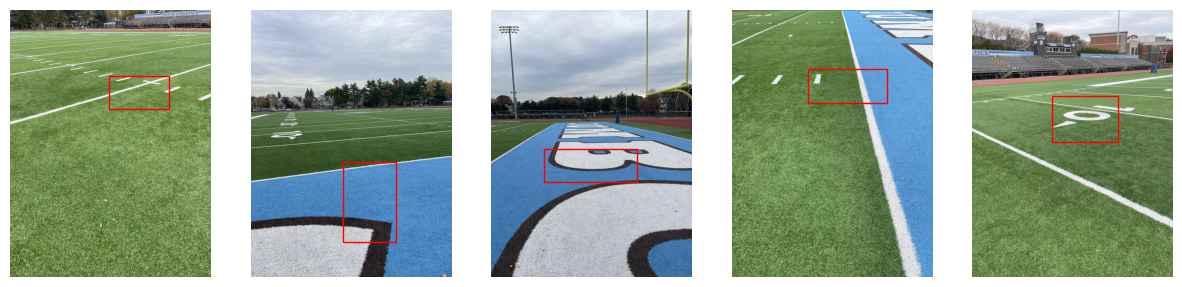

In [5]:
# Import mosaic parameters - arbitrarily obtained, can be modified
mosaic_params = np.load('../TurfData/GP_sections/mosaic_params.npy')
# Grab specified image points from local images 
gnav.grab_image_pts_tot(mosaic_params)

plt.figure(figsize=(15,8))
gnav.plot_gnd_pts()

In [6]:
# Generate projection of image sections 
for i in range(len(gnav.images_dict)):
    # STEP 1: Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # STEP 2: Transformation matrix moves from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # STEP 3: Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # STEP 4: Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # STEP 5: Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4


In [7]:
# Initial guess parameters 
# 5 image solution
scale, yaw, x_g, y_g = 80, np.deg2rad(140), -52, 20
# BEST after CONVERGENCE
scale = 80.14819958
yaw = 2.44777939
x_g = -55.46495001
y_g = 21.62910054

tform_guess = gnav.tform_create(x_g,y_g,0,0,0,yaw)
gnav.best_guess_tform = tform_guess
gnav.best_guess_scale = scale

# Implement
gnav.implement_guess(gnav.best_guess_tform, gnav.best_guess_scale)

In [8]:
# # Create visualization
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Image mosaic with reference map (initial guess)")

# gnav.mosaic_w_ref_visualization(vis)

### Divide each patch into micro-patches

- [x] Grab patch from ground image
- [x] Project patch onto satellite image (trapezoid)
- [x] Find bounds of trapezoid
- [x] Divide bounding box into uniform squares
- [x] Check which squares are fully within the trapezoid

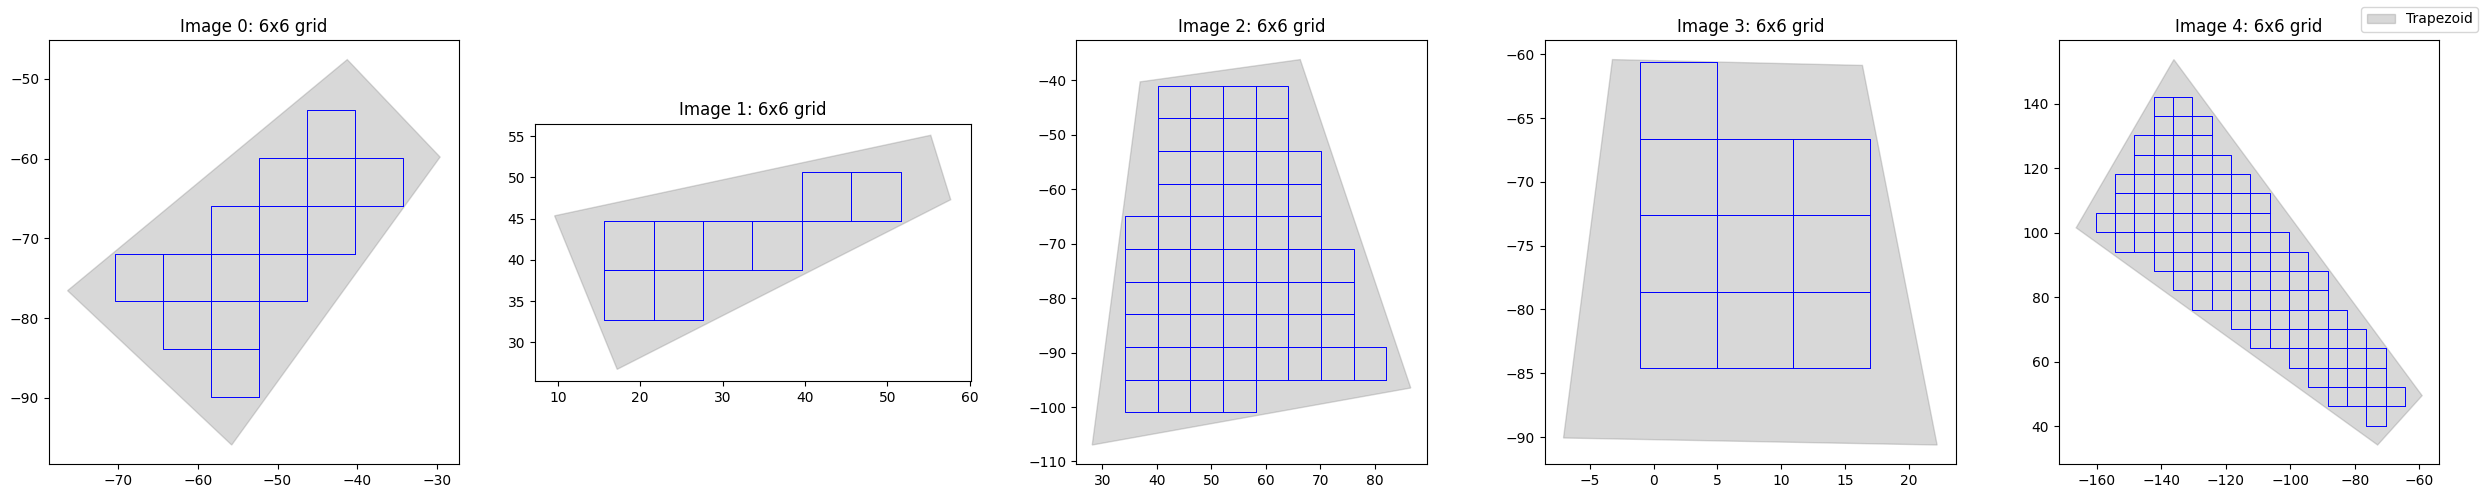

In [9]:
n = 6
micro_ps = gnav.micropatch_division(n)
gnav.plot_traps_w_microps(n)

In [10]:
print([len(micro_ps[i]) for i in range(5)])

[14, 8, 57, 10, 96]


In [11]:
# # Check that the points are at least proper

# # PLOTTING THE NEW SCENE MOSAIC

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Mosaic scene with satellite reference")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
# vis.add_geometry(axis_origin)

# # Add image patches
# # for i in range(len(gnav.images_dict)):
# # for i in range(2):
# #     cloud = o3d.geometry.PointCloud()
# #     cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[i]['pts'])
# #     cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
# #     vis.add_geometry(cloud)


# # Create point cloud for image points
# for i in range(len(gnav.images_dict)):
#     for j in range(len(micro_ps[i])):
#         # print(j)
#         cloud_micro = o3d.geometry.PointCloud()
#         cloud_micro.points = o3d.utility.Vector3dVector(micro_ps[i][j]['pts'])
#         # cloud_micro.paint_uniform_color([.75, 0.001*j, 0.002*j])
#         cloud_micro.colors = o3d.utility.Vector3dVector(micro_ps[i][j]['color_g'])
#         vis.add_geometry(cloud_micro)



# # Create point cloud for reference cloud (satellite)
# ref_cloud = o3d.geometry.PointCloud()
# ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
# ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)
# vis.add_geometry(ref_cloud)

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

### SSD Process:
- [x] Gather satellite points from each individual patch
- [x] Grab nearest neighbors of patch points 
- [x] Gather SSDs for each micropatch
- [ ] Calculate minimum for each patch
- [ ] Generate vector to minimum location
- [ ] Plot vectors across each micropatch

In [12]:
ssds_curr_micro = [{} for _ in range(len(gnav.images_dict))]

In [13]:
# Helper functions 

def grab_inside_sat_micro(imnum, pnum, shiftx, shifty):
    """
    Grabbing the satellite points which correspond to the specific micropatch. 
    Shifted according to SSD shift
    Input: Image number, micropatch number, shift in x and y
    Output: Satellite points within micropatch, colors within micropatch
    """

    # Use corners from micropatches to create a mask around the satellite image
    corners = gnav.micro_ps[imnum][pnum]['corners'].copy()
    # print("Shift in x: ", shiftx, "Shift in y: ", shifty)
    # print("Corners: \n", corners)
    corners[:,0] += shiftx
    corners[:,1] += shifty
    # print("Shift-adjusted corners: \n", corners)

    # Min and max, x and y
    minx, miny = np.min(corners[:,0]), np.min(corners[:,1])
    maxx, maxy = np.max(corners[:,0]), np.max(corners[:,1])
    # print("Max x: ", maxx, "Max y: ", maxy, "Min x: ", minx, "Min y: ", miny)
    mask = (
        (gnav.ref_pts[:,0] >= minx) & (gnav.ref_pts[:,0] <= maxx) &
        (gnav.ref_pts[:,1] >= miny) & (gnav.ref_pts[:,1] <= maxy)
    )
    # print("Mask: \n", mask)
    # Inside points and colors
    inside_pts = gnav.ref_pts[mask]
    inside_cg = gnav.ref_rgb[mask]
    # print("Inside points: \n", inside_pts)
    # print("Inside colors: \n", inside_cg)
    
    return inside_pts, inside_cg


def ssd_nxn_micro(n, imnum, pnum):
    """
    Gets the SSD values for an individual micropatch within an image
    Input: n (for nxn pixel shift), image number, micro-patch number 
    Output: SSD for the micropatch and all nxn shifts
    """

    # Downsample factor
    downs = 1
    ssds = np.zeros((2*n+1, 2*n+1))
    loc_pts = gnav.micro_ps[imnum][pnum]['pts'].copy()
    # print("Micropatch locations: \n", loc_pts)

    # Each nxn shift
    for shiftx in range(-n, n+1):
        for shifty in range(-n, n+1):
            # Get points inside corners for satellite image
            inside_pts, inside_cg = grab_inside_sat_micro(imnum, pnum, shiftx, shifty)
            # gnav.inside_pts = inside_pts # TESTING PURPOSES 
            # gnav.inside_cg = inside_cg # TESTING PURPOSES
            # Downsample points (grab only x and y)
            downsampled_pts = inside_pts[::downs, :-1] # Every 'downs'-th element
            downsampled_cg = inside_cg[::downs,0]
            # print("Color of downsampled satellite pts: \n", downsampled_cg)
            # Shift points 
            shifted_loc_pts = loc_pts + np.array([shiftx, shifty, 0])
            # print("Shifted micropatch pts: \n":, shifted_loc_pts)

            # Build tree
            tree = cKDTree(shifted_loc_pts[:,:2])

            # Find nearest points and calculate intensities
            distances, indices = tree.query(downsampled_pts, k=1)
            nearest_intensities = gnav.micro_ps[imnum][pnum]['color_g'][indices,0] # CHECK THIS 
            # print("Nearest intensities: \n", nearest_intensities)
            # gnav.intensity_check = nearest_intensities # TESTING PURPOSES 
            # gnav.pts_check = shifted_loc_pts[indices] # TESTING PURPOSES

            # Calculate SSDS
            diffs = downsampled_cg - nearest_intensities
            # print("Differences: \n", diffs)
            ssd_curr = np.sum(diffs**2)

            # Store ssd value for the current shift
            ssds[shiftx + n, shifty + n] = ssd_curr
            # print("SSD = ", ssd_curr)

    return ssds

In [14]:
# # Loop through images and patches
# n_ssd = 5

# for imnum in range(len(gnav.images_dict)):
#     for mp in range(len(gnav.micro_ps[imnum])):
#         ssds = ssd_nxn_micro(n_ssd, imnum, mp)
#         ssds_curr_micro[imnum][mp] = ssds
#     print(f'Done image {imnum}')

In [15]:
# # Save data as pickle 
# fn = 'ssd_test_6x6_5n.pkl'
# with open(fn, 'wb') as f:
#     pickle.dump(ssds_curr_micro, f)

In [16]:
# Import pickle data structure so we do not have to run again
# Load
with open('ssd_test_6x6_5n.pkl', 'rb') as f:
    ssds_curr_micro_pkl = pickle.load(f)

### Minimum SSD and patch distribution 

In [17]:
gnav.ssds_curr_micro = ssds_curr_micro_pkl

In [18]:
gnav.distb_vecs = [{} for _ in range(gnav.im_num)]
gnav.distb_pts = [{} for _ in range(gnav.im_num)]
# print(gnav.distb_vecs)

In [19]:
# Helper functions

def dy_from_ssd_micro(n,imnum):
    """
    Takes SSD values and creates vectors from original position to minimum SSD location
    Inputs: n (shift max), image number
    Output: yi (correction vectors for each micropatch)
    """

    # Set extension pixel threshold
    extend = 5

    # Create vector from original position to minimum ssd location
    cor_vecs = np.zeros((len(gnav.ssds_curr_micro[imnum]), 2))
    base_vec = np.zeros((len(gnav.ssds_curr_micro[imnum]), 2))
    # print(cor_vecs)
    
    # For each micropatch 
    for mp in range(len(gnav.ssds_curr_micro[imnum])):
        ssds = gnav.ssds_curr_micro[imnum][mp]
        # print(ssds)
        idrow, idcol = np.unravel_index(np.argmin(ssds), ssds.shape)
        # print("IDrow, IDcol \n", idrow, idcol)
        # Define best shift 
        shiftx_min, shifty_min = idrow-n, idcol-n
        # print(f"Shift vector = {shiftx_min, shifty_min}\n")
        # CHECK IF MIN SSD IS ON THE EDGE
        # if shiftx_min == n or shifty_min == n:
        #     # *******
        #     # IMPLEMENT LATER 
        #     # ********

        # Insert correction vectors
        cor_vecs[mp] = shiftx_min, shifty_min
        # Base vector for satellite location
        sat_pts_forMean, __ = grab_inside_sat_micro(imnum, mp, 0,0) # mean of sat points 
        basex, basey = np.mean(sat_pts_forMean[:,0]), np.mean(sat_pts_forMean[:,1])
        base_vec[mp] = basex, basey

    # Create and stack point from vectors
    points_b = np.hstack((base_vec, np.zeros((len(gnav.ssds_curr_micro[imnum]), 1))))
    points_e = points_b + np.hstack((cor_vecs, np.zeros((len(gnav.ssds_curr_micro[imnum]), 1))))
    points = np.vstack((points_b, points_e))
    # print("\nBeginning of points: \n", points_b)
    # print("\nEnd of points: \n",points_e)
    # print("\nAll points: \n",points) # RETURNING THIS
    # print("\nCorrection Vectors: \n", cor_vecs)
    y_i = cor_vecs.reshape(-1,1)
    # print("\nCorrection Vectors reshaped: \n", y_i) # RETURNING THIS 
    
    print(f"Done image {imnum}")        
    
    # return y_i, points
    return cor_vecs, points # RETURNING DIFFERENT FORMAT FOR NOW...

In [20]:
# Grab correction vectors for each micro-patch
n_ssd = 5
for imnum in range(gnav.im_num):
    cor_vecs, points = dy_from_ssd_micro(n_ssd, imnum)
    gnav.distb_vecs[imnum] = cor_vecs
    gnav.distb_pts[imnum] = points

Done image 0
Done image 1
Done image 2
Done image 3
Done image 4


In [21]:
# Grab mean and variance for each micropatch 
gnav.distb_mean_var = [{} for _ in range(gnav.im_num)]
# Add mean and variance for each set of micropatch corrections 
for imnum in range(gnav.im_num):
    # Grab all micropatch corrections
    cor_vecs = gnav.distb_vecs[imnum]
    # print("Correction vectors:\n", cor_vecs)
    if cor_vecs.shape[0] > 1:
        # Mean and variance
        x_bar = np.mean(cor_vecs[:,0])
        y_bar = np.mean(cor_vecs[:,1])
        gnav.distb_mean_var[imnum]['mean'] = np.array([x_bar, y_bar])
        cov_matrix = np.cov(cor_vecs.T)
        # print("Numpy cov matrix:\n", cov_matrix)
        gnav.distb_mean_var[imnum]['cov'] = cov_matrix
        # # Calculating my own covariance matrix - checking 
        # muh = np.array([[x_bar],[y_bar]])
        # # print("AVG:\n", muh)
        # RP = np.zeros((2,2))
        # for mp in range(len(gnav.micro_ps[imnum])):
        #     mpVecx = cor_vecs[mp][0]
        #     mpVecy = cor_vecs[mp][1]
        #     rp = np.array([[mpVecx], [mpVecy]]) - muh
        #     rp = rp*rp.T
        #     RP += rp
        #     # print("RP JAWN:\n", rp)
        #     # print("Micropatch Vec:\n",mpVecx, mpVecy)
            
        # RP *= 1/(len(gnav.micro_ps[imnum])-1)
        # print("R_p: \n", RP)
        
    else:
        gnav.distb_mean_var[imnum]['mean'] = cor_vecs[0] if cor_vecs.shape[0] == 1 else np.array([0,0])
        gnav.distb_mean_var[imnum]['cov'] = np.zeros((2,2))
    # print(x_bar, y_bar)
    
print(gnav.distb_mean_var[4])

{'mean': array([0.96875, 1.375  ]), 'cov': array([[15.48322368,  0.19078947],
       [ 0.19078947, 14.15263158]])}


In [22]:
# PLOT 2D Correction vectors on each micropatch
def plot_microps_w_corVecs():
    """ 
    Use matplotlib to plot the patch trapezoids with the grids of the micropatches AND error correction vectors 
    Input: Nada
    Output: Subplot with trapezoids and micropatch grids
    """

    num_imgs = len(gnav.images_dict)
    # fig, axes = plt.subplots(1, num_imgs, figsize=(5*num_imgs, 5))
    fig, axes = plt.subplots(num_imgs, 1, figsize=(10, 20))

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes
        
        # Polygon bound of mosaic points 
        # Get corners
        pts_curr = gnav.im_pts_best_guess[i]['pts']
        corners = gnav.im_pts_2d[i]['corners']
        # Define corner indices 
        idxs = [0, -corners[2], -1, corners[2]-1]
        # Grab corner points
        pts_corners = np.array(pts_curr[idxs])
        # Create polygon 
        poly = Polygon(pts_corners[:,:2])
        # Draw the base trapezoid
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.3, color='gray', label='Trapezoid')

        # Draw micropatches from corners
        for j in range(len(gnav.micro_ps[i])):
            corners = gnav.micro_ps[i][j]['corners']
            if corners is None or len(corners) == 0:
                continue

            # Close the polygon by repeating the first point
            corners_closed = np.vstack([corners, corners[0]])
            xs, ys = corners_closed[:, 0], corners_closed[:, 1]

            ax.plot(xs, ys, color='blue', linewidth=0.7)

        # Draw CORRECTION VECTORS for each micropatch
        # for mp in range(len(gnav.ssds_curr_micro[i])):
        pts_corr = gnav.distb_pts[i]
        mps = len(gnav.ssds_curr_micro[i])
        # Split into base and end points
        base = pts_corr[:mps]
        end = pts_corr[mps:]
    
        # Compute vector components
        u = end[:, 0] - base[:, 0]
        v = end[:, 1] - base[:, 1]
    
        # Plot arrows
        ax.quiver(base[:, 0], base[:, 1], u, v,
                  angles='xy', scale_units='xy', scale=1,
                  color='red', width=0.004, label='Correction Vectors')
    
        # Optionally: mark start and end points
        ax.scatter(base[:, 0], base[:, 1], color='black', s=10, label='Base')
        ax.scatter(end[:, 0], end[:, 1], color='orange', s=10, label='End')
        
        # print(mps)
        # print(pts_corr)
        
        ax.set_aspect('equal')
        ax.set_title(f"Image {i}")

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels() if num_imgs > 1 else ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()


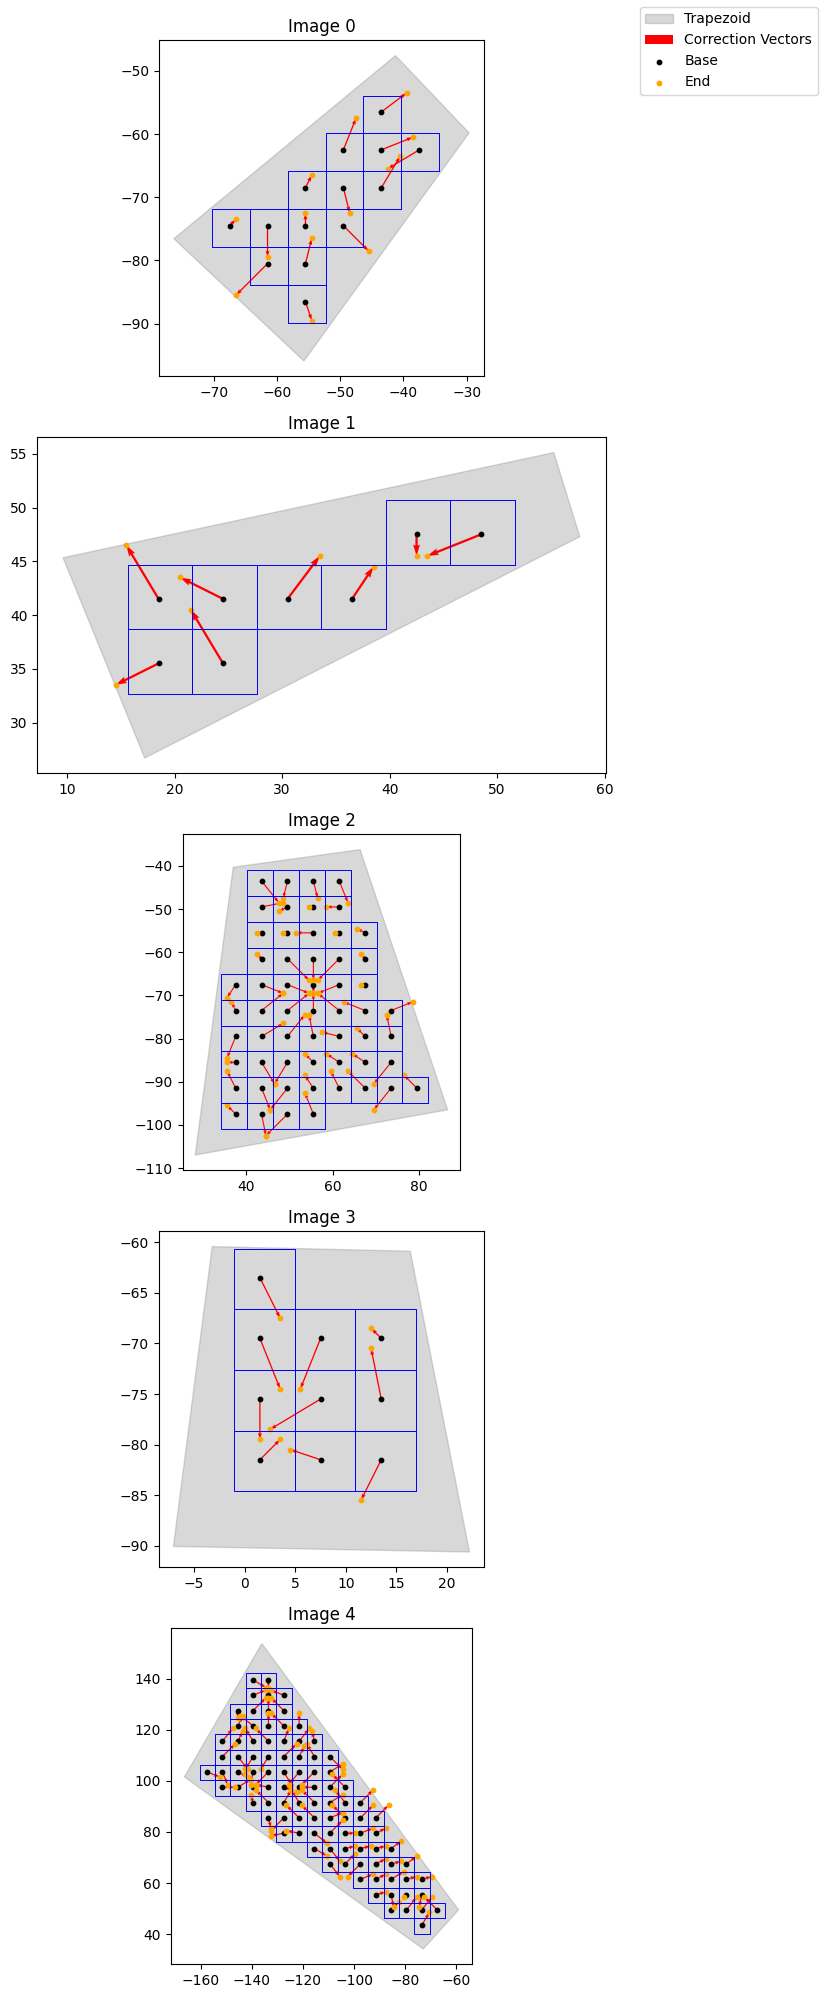

In [23]:
# Plot micropatches and error correction vectors

plot_microps_w_corVecs()

In [24]:
# for i in range(5):
#     print(f'Distribution vectors for image {i}: \n', gnav.distb_vecs[i])

## Error distribution plots 

WHAT ARE WE AFTER 
- Displaying mean and std for micropatch correction vectors
- For each grid (5,6,8,10,12)

PLOT:
1. [x] Plotting x and y from zero - avg distance from trough
2. [x] Mean and std for each patch per grid 

In [25]:
# Plotting x and y from zero - avg distance from trough - bullet 1
def plot_distb_vecs():
    """
    Plots the x and y offset correction vector for each micropatch per image
    Input: nada 
    Output: 5 plots (or # of images) with x and y correction vector points
    """
    num_imgs = gnav.im_num
    fig, axes = plt.subplots(1, num_imgs, figsize=(20, 4 * num_imgs), squeeze=False)
    axes = axes.flatten()

    for i in range(num_imgs):
        ax = axes[i] if num_imgs > 1 else axes

        # grab correction vectors
        xs = gnav.distb_vecs[i][:,0]
        ys = gnav.distb_vecs[i][:,1]
        ax.scatter(xs,ys, s=10)

        # Mean and cov
        mean = gnav.distb_mean_var[i]['mean']
        cov = gnav.distb_mean_var[i]['cov']
        # Draw ellipse
        if np.any(cov) and not np.isnan(cov).any():
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            vals, vecs = vals[order], vecs[:, order]
            angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            width, height = 2 * np.sqrt(vals)  # 1-sigma ellipse

            ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          color='red', alpha=0.3, lw=2, label='Covariance (1σ)')
            ax.add_patch(ell)

            # Mark the mean
            ax.scatter(*mean, color='red', s=40, marker='x', label='Mean')

        # Styling
        ax.set_title(f"Image {i}: grid = {n}x{n}", fontsize=12)
        ax.set_xlim([-6, 6])
        ax.set_ylim([-6, 6])
        ax.set_xlabel("X Offset")
        ax.set_ylabel("Y Offset")
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, linestyle='--', alpha=0.6)
        # ax.set_title(f"Image {i}")

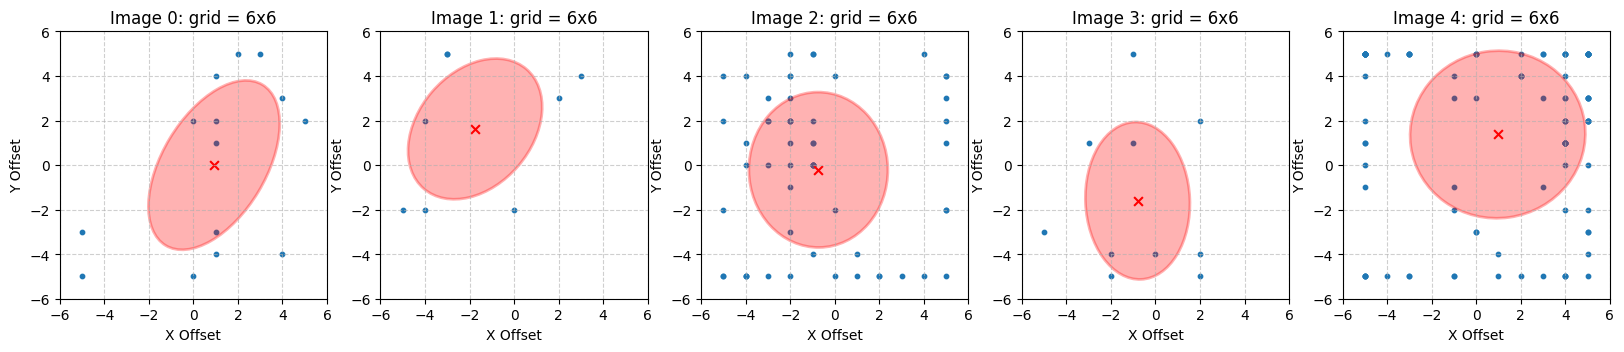

In [26]:
plot_distb_vecs()